Dataset Shape: (15420, 33)

Columns: ['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy']

First 5 rows:
  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban       

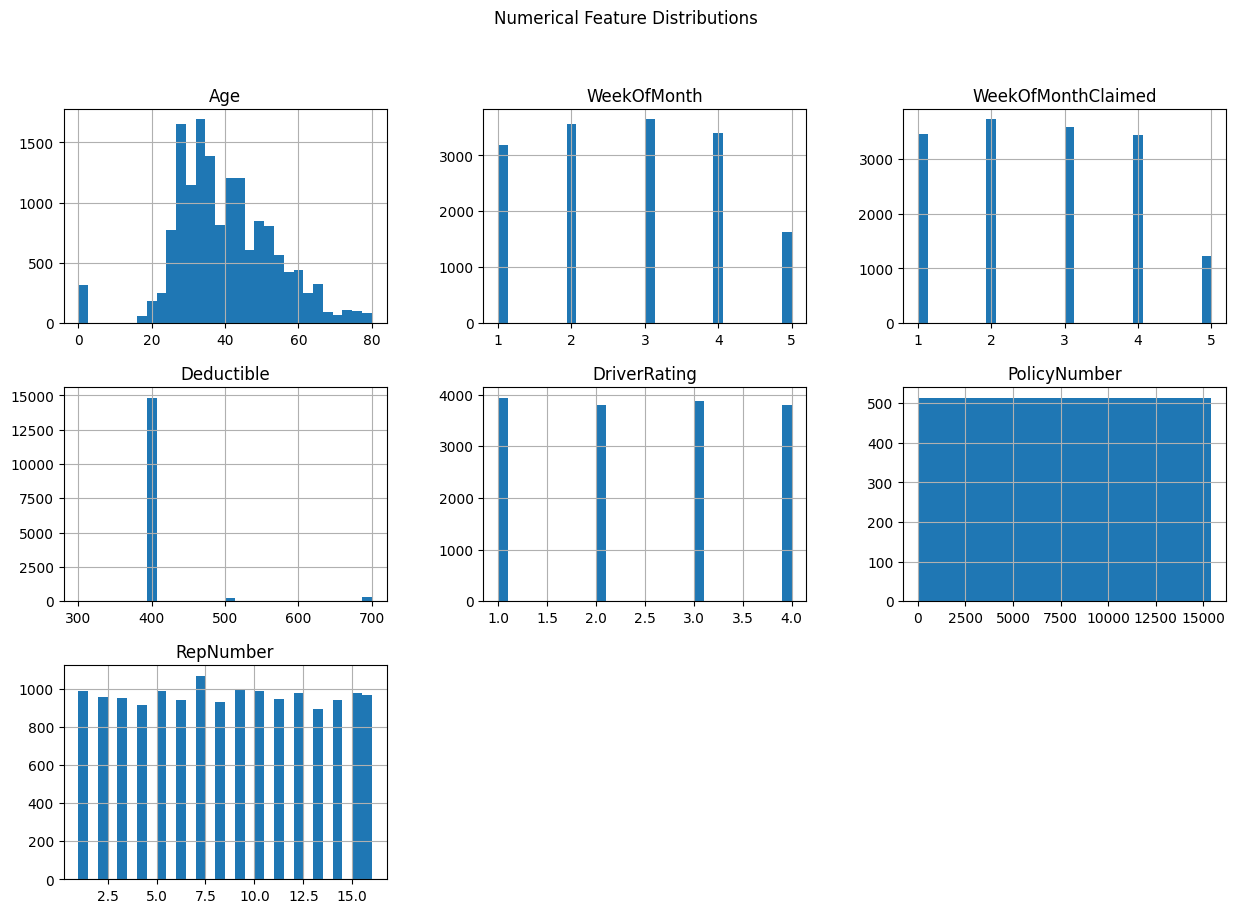

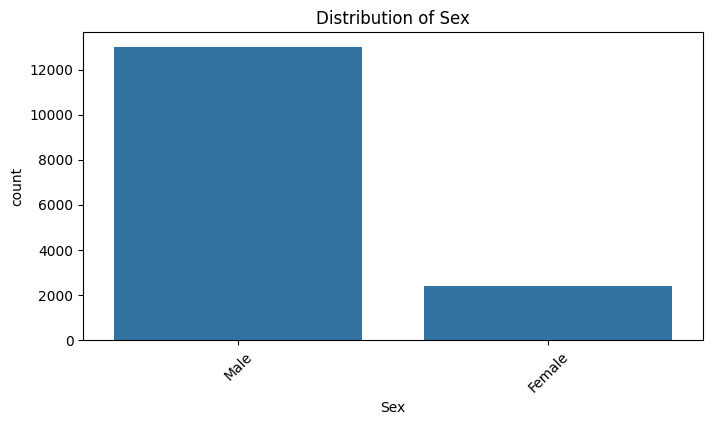

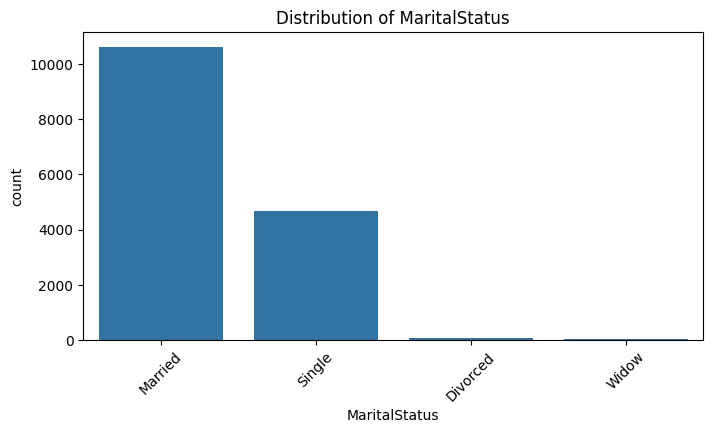

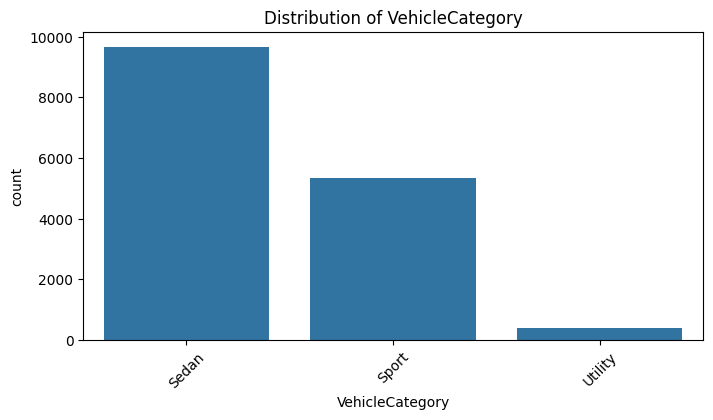

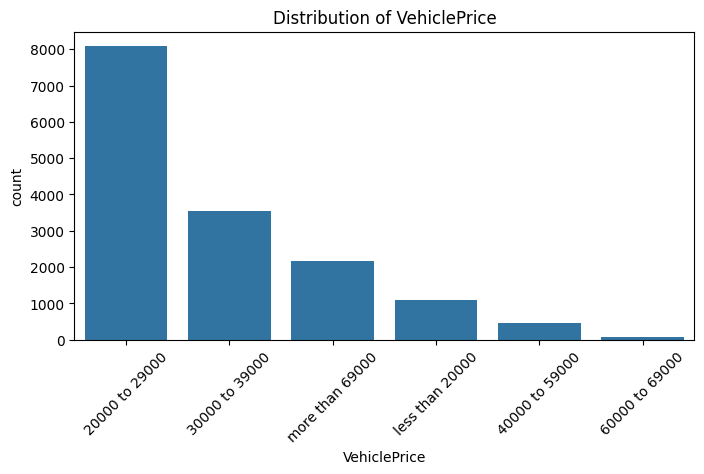

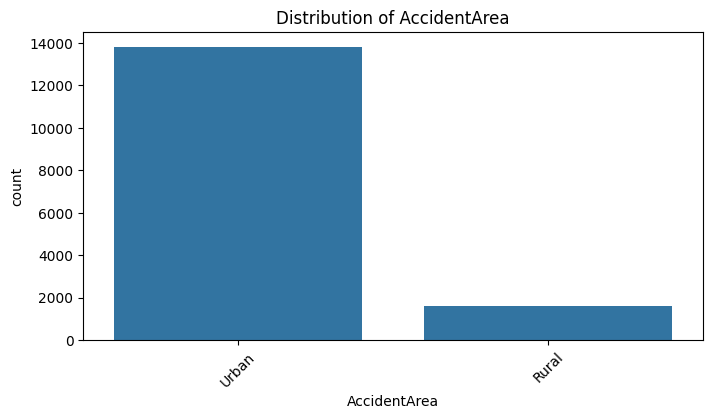

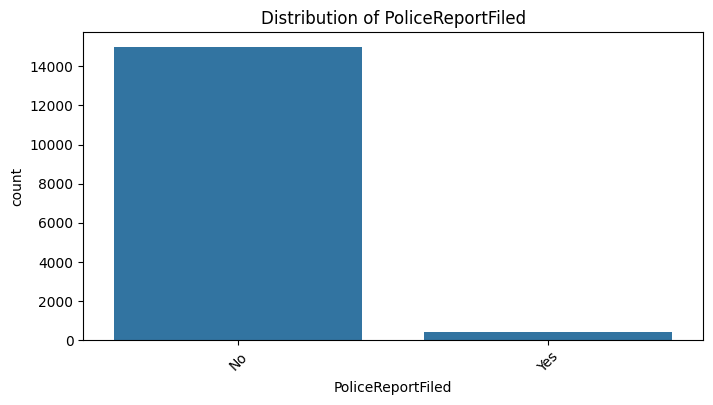

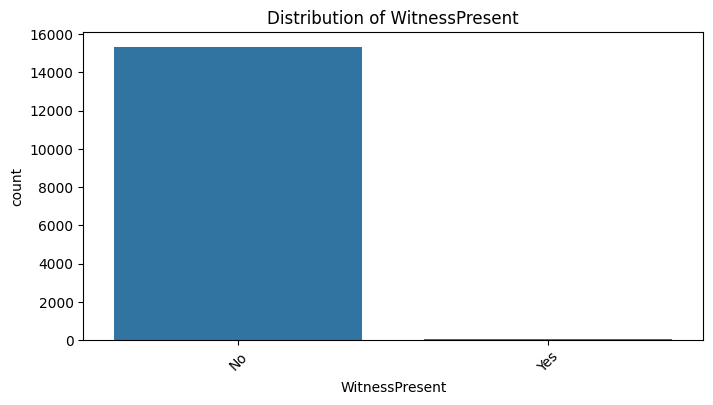

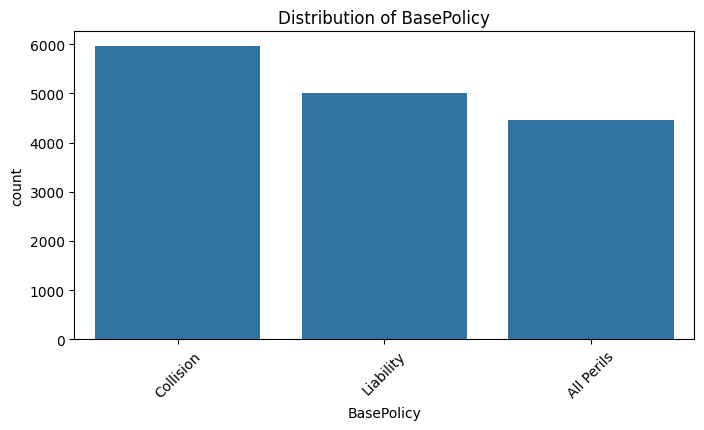


Data ready for modeling!


In [1]:
# -----------------------------------------
#  Insurance Claim Anomaly Detection (Unsupervised)
# -----------------------------------------

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

# 2. Load Dataset
file_path = 'fraud_oracle.csv'  # Adjust path if needed

df = pd.read_csv(file_path)

# 3. Initial Exploration
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

# 4. Basic EDA
## Distribution of numerical features
numerical_cols = ['Age', 'WeekOfMonth', 'WeekOfMonthClaimed', 'Deductible', 'DriverRating', 'PolicyNumber', 'RepNumber']

df[numerical_cols].hist(bins=30, figsize=(15,10))
plt.suptitle('Numerical Feature Distributions')
plt.show()

## Categorical feature distributions
categorical_cols = ['Sex', 'MaritalStatus', 'VehicleCategory', 'VehiclePrice', 'AccidentArea', 'PoliceReportFiled', 'WitnessPresent', 'BasePolicy']

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

# 5. Prepare for Modeling
## Drop label column for now (FraudFound_P)
X = df.drop(columns=['FraudFound_P'])

## Encode categorical features
le = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = le.fit_transform(X[col])

## Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nData ready for modeling!")


Explained Variance Ratios: [0.08237033 0.07672303]


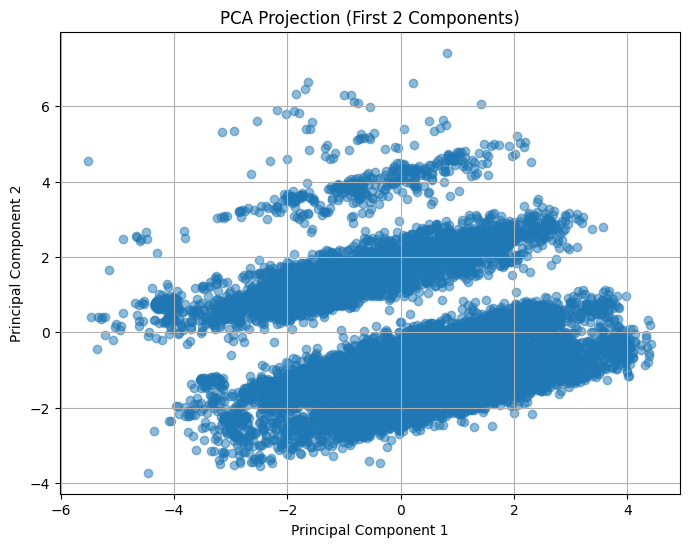

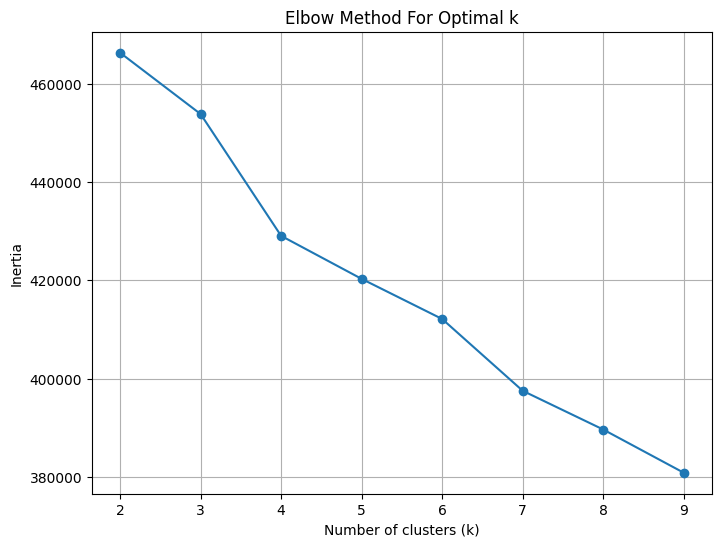

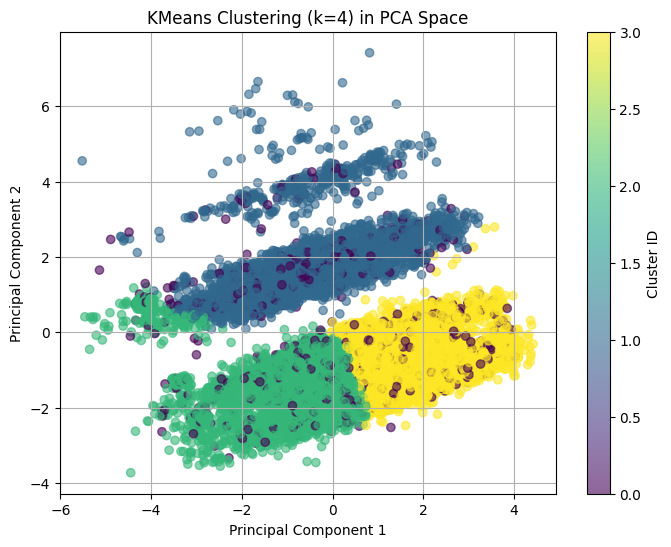

Silhouette Score for k=4: 0.0615


In [2]:
# -----------------------------------------
# 6. Dimensionality Reduction with PCA
# -----------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained Variance Ratios:", pca.explained_variance_ratio_)

# Scatter plot of PCA results
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA Projection (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# -----------------------------------------
# 7. Clustering with KMeans
# -----------------------------------------
# Determine optimal k using the Elbow Method
inertia = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8,6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Fit KMeans with chosen k (e.g., k=4 based on elbow method)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Plot clustering result
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('KMeans Clustering (k=4) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
print(f"Silhouette Score for k={k_optimal}: {silhouette_avg:.4f}")

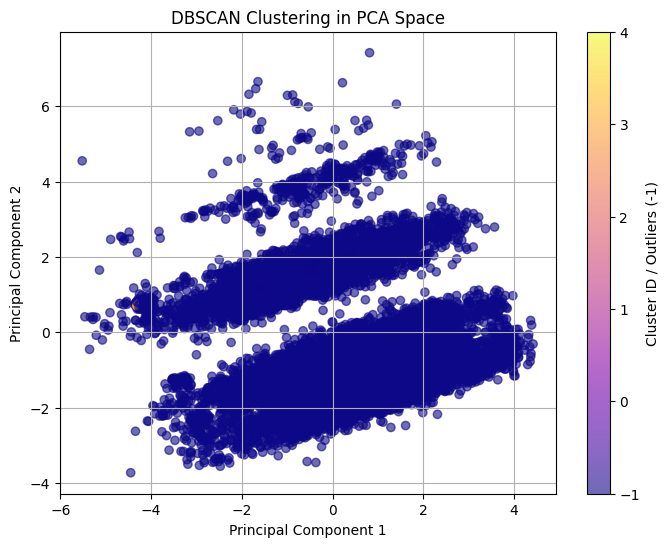

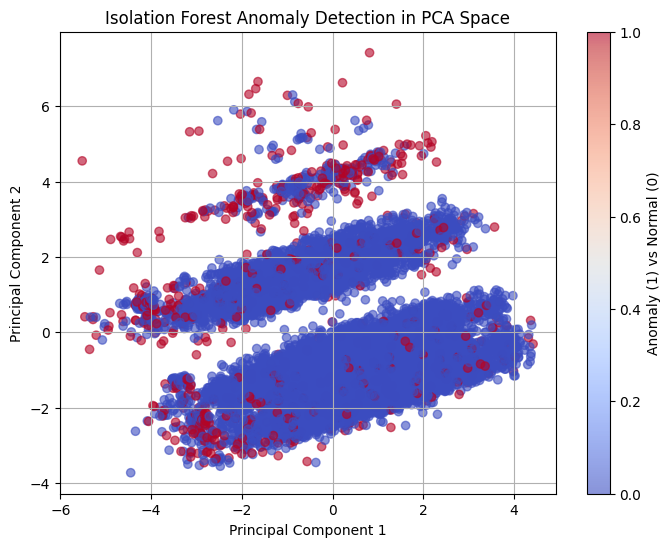

Number of anomalies detected: 771 out of 15420 samples


In [3]:
# -----------------------------------------
# 8. Clustering with DBSCAN
# -----------------------------------------
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Plot DBSCAN results
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.6)
plt.title('DBSCAN Clustering in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster ID / Outliers (-1)')
plt.grid(True)
plt.show()

# -----------------------------------------
# 9. Anomaly Detection with Isolation Forest
# -----------------------------------------
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
iso_labels = isolation_forest.fit_predict(X_scaled)

# Convert labels to 0 (normal) and 1 (anomaly)
iso_labels = np.where(iso_labels == -1, 1, 0)

# Plot Isolation Forest results
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iso_labels, cmap='coolwarm', alpha=0.6)
plt.title('Isolation Forest Anomaly Detection in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Anomaly (1) vs Normal (0)')
plt.grid(True)
plt.show()

print(f"Number of anomalies detected: {iso_labels.sum()} out of {len(iso_labels)} samples")


In [5]:
# Discussion:
print("\nDiscussion:")
print("- KMeans grouped the claims into distinct clusters; some groups may represent different risk profiles.")
print("- DBSCAN helped identify outliers without assuming the number of clusters.")
print("- Isolation Forest flagged about 5% of claims as anomalies.")
print("- Some anomalies aligned with actual fraud cases, showing the model's potential.")
print("- This system could prioritize suspicious claims for investigation, saving insurers time and cost.")


Discussion:
- KMeans grouped the claims into distinct clusters; some groups may represent different risk profiles.
- DBSCAN helped identify outliers without assuming the number of clusters.
- Isolation Forest flagged about 5% of claims as anomalies.
- Some anomalies aligned with actual fraud cases, showing the model's potential.
- This system could prioritize suspicious claims for investigation, saving insurers time and cost.


In this project, I explored the application of unsupervised machine learning methods to detect potential insurance claim fraud without using labeled data. Through exploratory data analysis, dimensionality reduction with PCA, clustering with KMeans and DBSCAN, and anomaly detection using Isolation Forest, I identified meaningful patterns and surfaced potentially fraudulent claims. Isolation Forest flagged approximately 5% of claims as anomalies, with several corresponding to known fraud cases, demonstrating the practical utility of these methods. This approach offers insurers a scalable way to prioritize claim investigations early, helping to reduce costs and mitigate fraud risk. Future work could explore semi-supervised learning techniques, deeper anomaly detection methods, and real-time system integration to further enhance performance.